In [793]:
%matplotlib inline

import string
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
pd.options.display.max_columns =50

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

from statistics import *
import concurrent.futures
import time
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from matplotlib.colors import ListedColormap
import seaborn as sns
color = sns.color_palette()

import nltk
from tqdm import tqdm
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from collections import defaultdict

import unicodedata
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import textstat

import re
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')

In [743]:
nltk.download('stopwords')
stop=set(stopwords.words('english'))



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davidkolb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [672]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [673]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [674]:
train.head(20)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [675]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
id          3263 non-null int64
keyword     3237 non-null object
location    2158 non-null object
text        3263 non-null object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


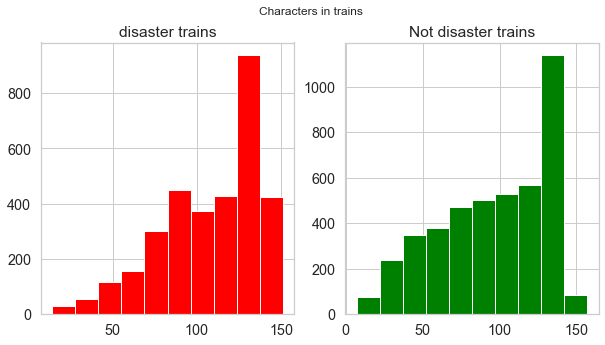

In [676]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
train_len=train[train['target']==1]['text'].str.len()
ax1.hist(train_len,color='red')
ax1.set_title('disaster trains')
train_len=train[train['target']==0]['text'].str.len()
ax2.hist(train_len,color='green')
ax2.set_title('Not disaster trains')
fig.suptitle('Characters in trains')
plt.show()

In [677]:
#Check missing train data ratios 
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :train_na})
missing_data.head()

,Missing Ratio
location,33.272035
keyword,0.801261


In [678]:
#Check missing test data ratios 
test_na = (test.isnull().sum() / len(test)) * 100
test_na = test_na.drop(test_na[test_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :test_na})
missing_data.head()

,Missing Ratio
location,33.864542
keyword,0.796813


In [679]:
#check for skewwness in data 
skewness = pd.DataFrame(train.skew(axis = 0, skipna = True).sort_values(ascending=False), columns=['Skew'])
skewness

,Skew
target,0.284243
id,0.007607


In [680]:
#Add meta data features
# word_count
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
test['word_count'] = test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train['unique_word_count'] = train['text'].apply(lambda x: len(set(str(x).split())))
test['unique_word_count'] = test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train['stop_word_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test['stop_word_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
train['url_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test['url_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train['mean_word_length'] = train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test['mean_word_length'] = test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train['char_count'] = train['text'].apply(lambda x: len(str(x)))
test['char_count'] = test['text'].apply(lambda x: len(str(x)))

# punctuation_count
train['punctuation_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test['punctuation_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
train['hashtag_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test['hashtag_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
train['mention_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test['mention_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

In [681]:
# fig =plt.figure(figsize=(15,15),dpi=100)
# sns.set_context('notebook',font_scale=1.3)
# sns.set_style('whitegrid')
# g=sns.pairplot(train[['word_count',
#                 'unique_word_count',
#                 'stop_word_count',
#                 'char_count',
#                 'target']],hue='target')

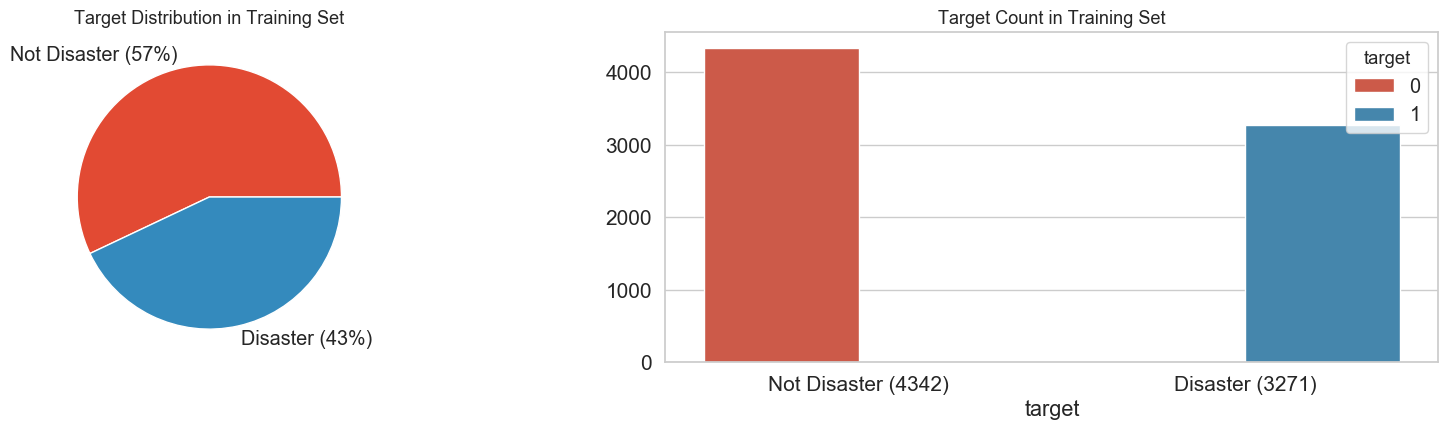

In [682]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

train.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=train['target'], hue=train['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

In [683]:
# N-gram analysis
def get_top_train_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

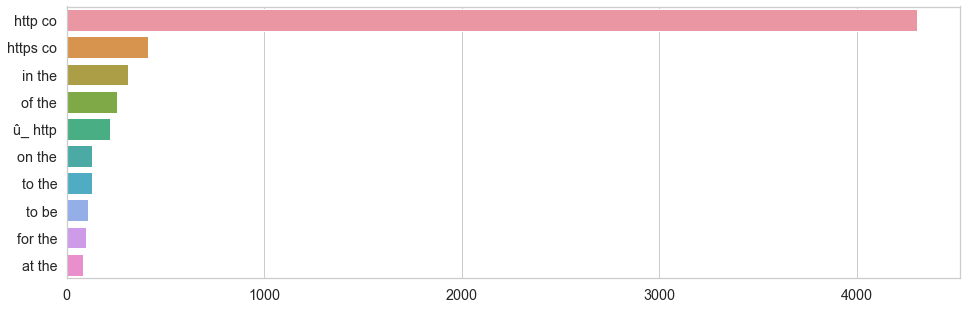

In [684]:
plt.figure(figsize=(16,5))
top_train_bigrams=get_top_train_bigrams(train['text'])[:10]
x,y=map(list,zip(*top_train_bigrams))
sns.barplot(x=y,y=x)

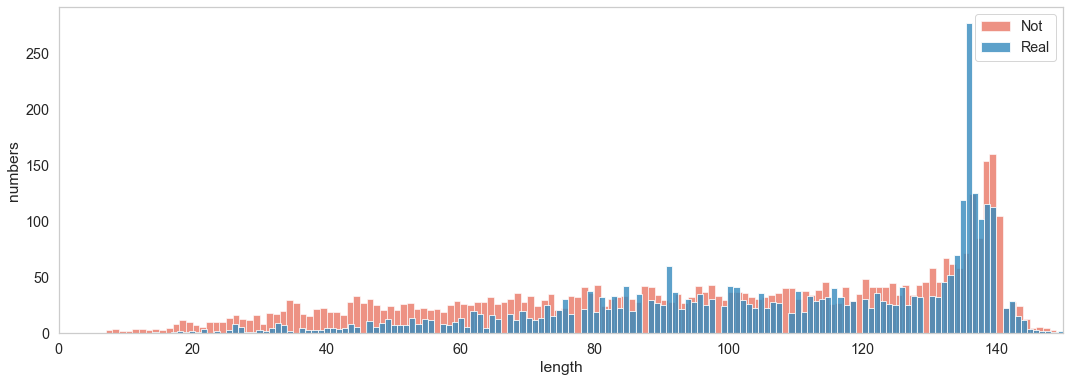

In [685]:
# Characters per tweet
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(train[train['target'] == 0]['char_count'], alpha = 0.6, bins=bins, label='Not')
plt.hist(train[train['target'] == 1]['char_count'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

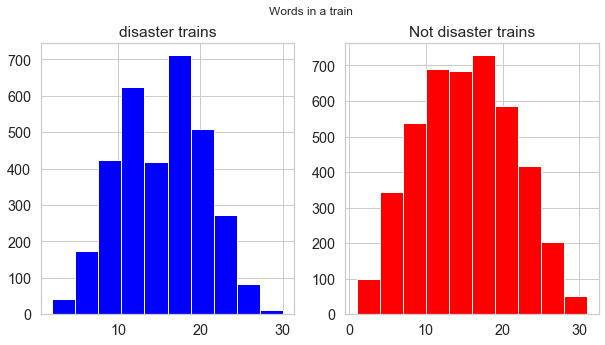

In [686]:
# Number of words in train
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
train_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(train_len,color='blue')
ax1.set_title('disaster trains')
train_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(train_len,color='red')
ax2.set_title('Not disaster trains')
fig.suptitle('Words in a train')
plt.show()

Text(0.5, 0.98, 'Average word length in each train')

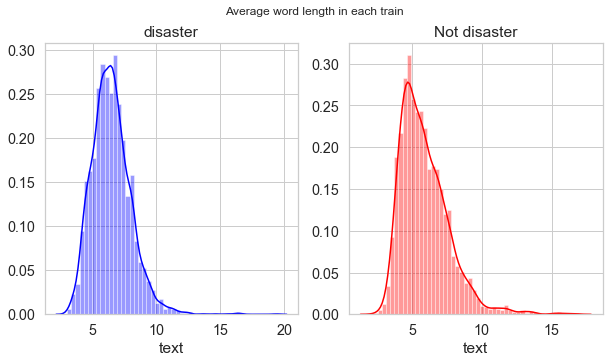

In [687]:
#Average word length in a train
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue')
ax1.set_title('disaster')
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each train')

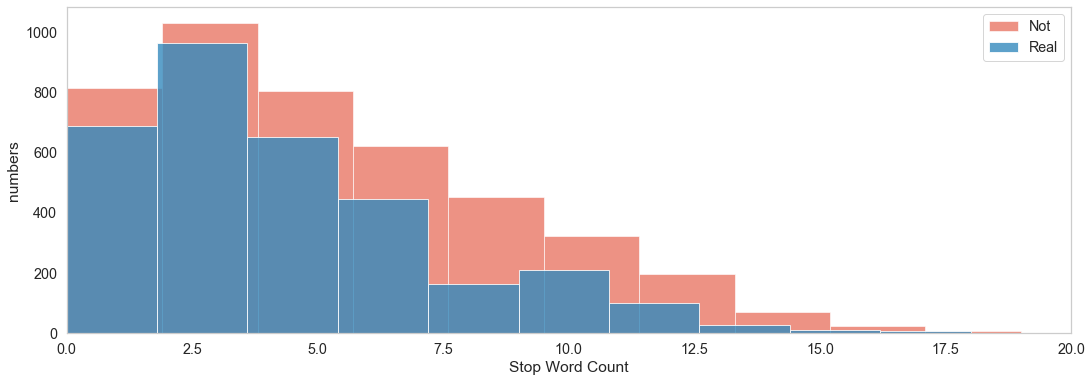

In [688]:
# stop_word_count
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 10
plt.hist(train[train['target'] == 0]['stop_word_count'], alpha = 0.6, bins=bins, label='Not')
plt.hist(train[train['target'] == 1]['stop_word_count'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('Stop Word Count')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,20)
plt.grid()
plt.show()

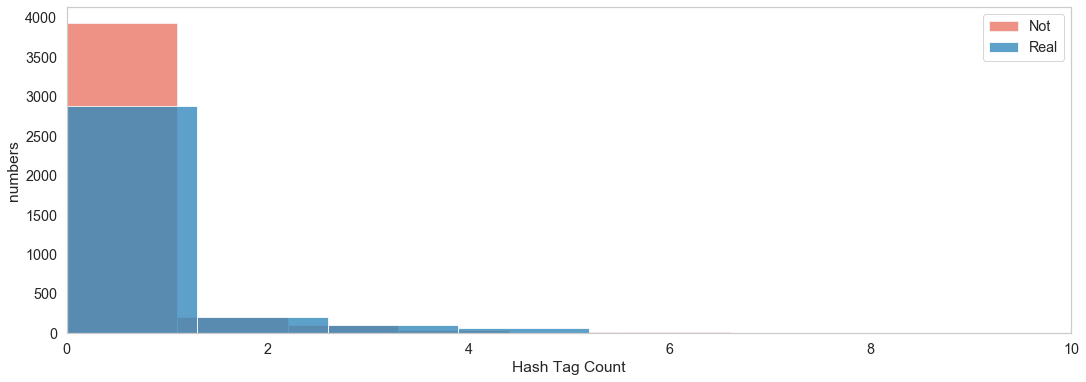

In [689]:
# hashtag_count
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 10
plt.hist(train[train['target'] == 0]['hashtag_count'], alpha = 0.6, bins=bins, label='Not')
plt.hist(train[train['target'] == 1]['hashtag_count'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('Hash Tag Count')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,10)
plt.grid()
plt.show()

In [690]:
#Create a list of words
def create_corpus(target):
    corpus=[]
    for x in train[train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

#Create list of stop words
def stop_words(data):
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
    return dic

#Create list of puntcuation
def punt_words(data):
    dic=defaultdict(int)
    special = string.punctuation
    for i in (corpus):
        if i in special:
            dic[i]+=1
    return dic

<BarContainer object of 10 artists>

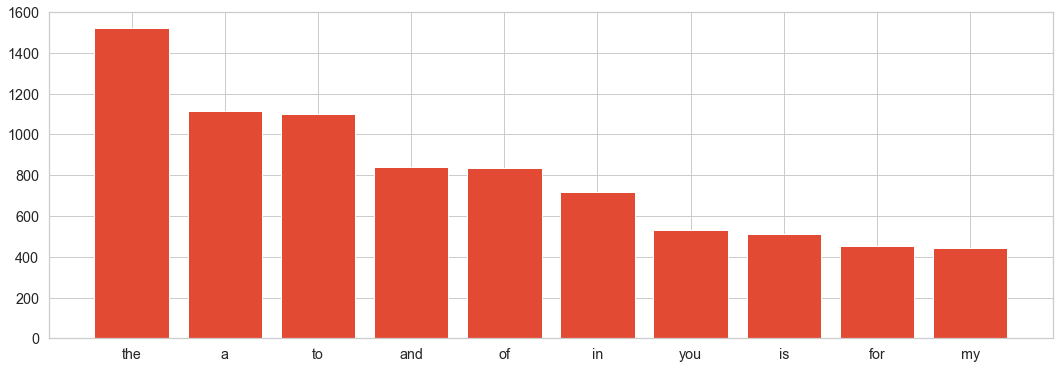

In [691]:
# Common stop words in class 0
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

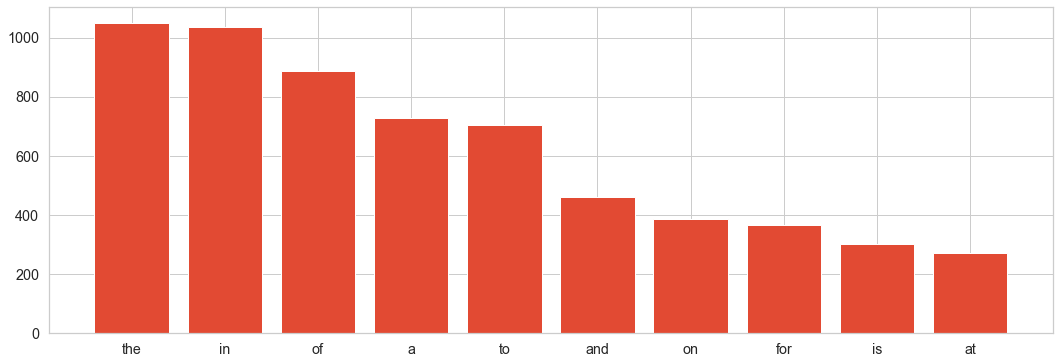

In [692]:
# Common stop words in class 1
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

# Cleaing the Data

In [693]:
def remove_whitespace(data):
    return data.strip()

In [694]:
def remove_URL(data):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',data)

In [695]:
def remove_html(data):
    html=re.compile(r'<.*?>')
    return html.sub(r'',data)

In [696]:
def remove_emoji(data):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', data)

In [697]:
def remove_accented_chars(data):
    return unicodedata.normalize('NFKD', data).encode('ascii', 'ignore').decode('utf-8', 'ignore')

In [698]:
def remove_punctuation(data):
    table=str.maketrans('','',string.punctuation)
    return data.translate(table)

In [699]:
def single_char(data):
    new_data=''
    for w in data:
        print(w)
        if len(w) > 1:
            print(w)
            new_data = new_data +  " " + w
    
    return new_data

In [700]:
def remove_special_characters(data, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    data = re.sub(pattern, '', data)
    return data

In [701]:
def convert_lower_case(data):
    return data.lower()

In [702]:
def tokenise(data):
    data = word_tokenize(data)
    return data

In [703]:
def remove_stop_words(data):
    filtered_sentence = [w for w in data if not w in stop_words] 
    return filtered_sentence

In [704]:
def stemming(data):
    data.apply(lambda x: [stemmer.stem(e) for e in x])
    return data

In [705]:
def lemmatise(data):
    lemmatizer = WordNetLemmatizer()
    data.apply(lambda x: [lemmatizer.lemmatize(e) for e in x])
    return data 

In [706]:
stop_words = set(stopwords.words('english')) 
stemmer = SnowballStemmer("english")

In [707]:
def nlp_clean(data):
    data = remove_URL(data)
    data = remove_html(data)
    data = remove_emoji(data)
    data = remove_whitespace(data)    
    data = remove_accented_chars(data) 
    data = remove_special_characters(data)
    data = remove_punctuation(data)
    data = convert_lower_case(data)
    return data
    
def nlp_tokenise(data):
    data = tokenise(data)
    data = remove_stop_words(data)
    return data
     
def nlp_normalise(data):
    data = stemming(data)
    data = lemmatise(data)
    return data

In [708]:
# Run preprossing steps to clean data
train['text']=train['text'].apply(lambda x : nlp_clean(x))
test['text']=test['text'].apply(lambda x : nlp_clean(x))

In [709]:
# Run steps to remove stop words
train['text']=train['text'].apply(lambda x : nlp_tokenise(x))
test['text']=test['text'].apply(lambda x : nlp_tokenise(x))

In [710]:
train['text']

0       [deeds, reason, earthquake, may, allah, forgiv...
1           [forest, fire, near, la, ronge, sask, canada]
2       [residents, asked, shelter, place, notified, o...
3       [13000, people, receive, wildfires, evacuation...
4       [got, sent, photo, ruby, alaska, smoke, wildfi...
                              ...                        
7608    [two, giant, cranes, holding, bridge, collapse...
7609    [ariaahrary, thetawniest, control, wild, fires...
7610                [m194, 0104, utc5km, volcano, hawaii]
7611    [police, investigating, ebike, collided, car, ...
7612    [latest, homes, razed, northern, california, w...
Name: text, Length: 7613, dtype: object

In [711]:
# Find and wordcloud common words
all_train_words = []
for text in train['text']:
    for word in text:
        all_train_words.append(word)

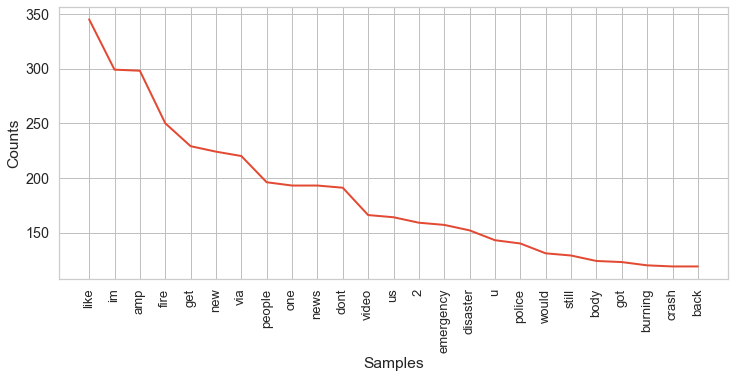

In [712]:
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_train_words)
fd.plot(25,cumulative=False)
# log-log of all words 
word_counts = sorted(Counter(all_train_words).values(), reverse=True)

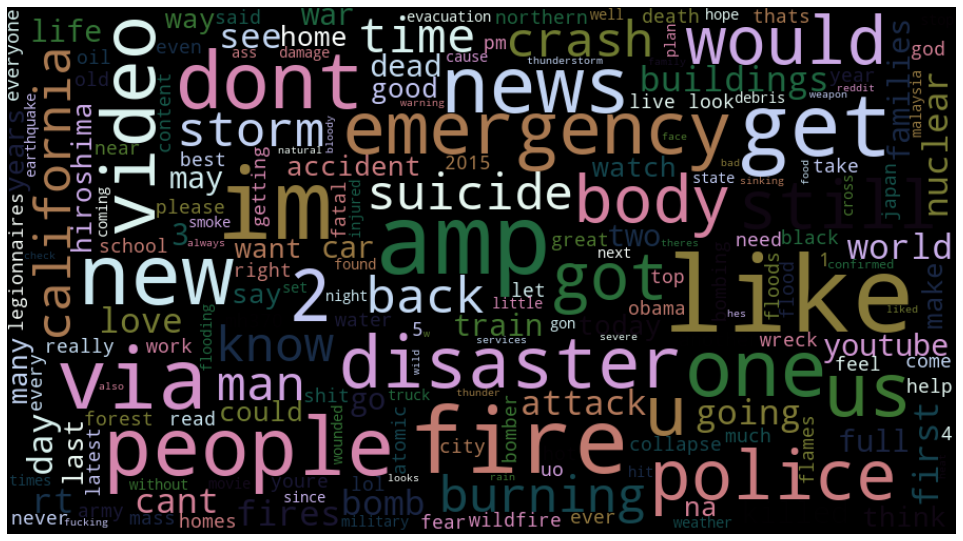

In [713]:
# create a word frequency dictionary
wordfreq = Counter(all_train_words)
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=200,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='cubehelix_r',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [714]:
train['text']

0       [deeds, reason, earthquake, may, allah, forgiv...
1           [forest, fire, near, la, ronge, sask, canada]
2       [residents, asked, shelter, place, notified, o...
3       [13000, people, receive, wildfires, evacuation...
4       [got, sent, photo, ruby, alaska, smoke, wildfi...
                              ...                        
7608    [two, giant, cranes, holding, bridge, collapse...
7609    [ariaahrary, thetawniest, control, wild, fires...
7610                [m194, 0104, utc5km, volcano, hawaii]
7611    [police, investigating, ebike, collided, car, ...
7612    [latest, homes, razed, northern, california, w...
Name: text, Length: 7613, dtype: object

In [716]:
train['text2'] = train['text']
test['text2'] = test['text']

In [717]:
#Join Data
def combine_text(list_of_text):
    combined_text = ''
    for word in list_of_text:
        combined_text = combined_text + ' ' + word
    return combined_text

 deeds reason earthquake may allah forgive us
 forest fire near la ronge sask canada
 residents asked shelter place notified officers evacuation shelter place orders expected
 13000 people receive wildfires evacuation orders california
 got sent photo ruby alaska smoke wildfires pours school
 rockyfire update california hwy 20 closed directions due lake county fire cafire wildfires
 flood disaster heavy rain causes flash flooding streets manitou colorado springs areas
 im top hill see fire woods
 theres emergency evacuation happening building across street
 im afraid tornado coming area
 three people died heat wave far
 haha south tampa getting flooded hah wait second live south tampa gon na gon na fvck flooding
 raining flooding florida tampabay tampa 18 19 days ive lost count
 flood bago myanmar arrived bago
 damage school bus 80 multi car crash breaking
 whats man
 love fruits
 summer lovely
 car fast
 goooooooaaaaaal
 ridiculous
 london cool
 love skiing
 wonderful day
 looooool
 w

 2 cars collide 1 crashes building two cars collided intersection sent one vehicle crashingu
 san antonio stars head coach dan hughes carted locker room one guards collided
 bicyclesuv accident mesick police say bicyclist entered onto west m115 collided boat
 even worse looks american constitutional system collided new politicu
 omg omg omg justinbieber harrystyles collided nuclear accident cern oo harrybecareful
 16 dead russia bus accident least 16 people killed 26 others injured two buses collided
 well journey get home train collided cows track
 crews working restore power southwest omaha vehicle collided utility pole
 stepkans media two confirmed dead boat travelling collided lvictoria
 cyclist collided runner roanoke greenway wins 300000 civil verdict roanoke times cyclist c
 cant watch pvris im sad bc collided another set
 motorcyclist bicyclist injured denver collision broadway least two people taken localu
 zojadelin literally almost head collision us today pilot knob
 north s

 goulburn man henry van bilsen missing emergency services searching goulburn man disappeared hisu
 hiring read latest job opening emergency department psychiatric rn 90 fte day
 providence health amp services emergency services supervisor emergency department kodiak ak healthcare job
 want work tarzana ca view latest opening nursing job jobs hiring
 beyond stressed beyond hysteria grey misty indifference complete shutdown emergency services brain
 services returning normal southline medical emergency yennora urgent track equipment repairs cabramatta earlier
 swayoung01 hi thought recognised smile believe emergency services best performing arts followers simon
 doctors nurses new pediatric emergency department specialized child services
 missionhills ca nursing registered nurse emergency department full time providence health amp services
 saw car i77 fully engulfed flames hahah
 men escape car engulfed flames parleys canyon crews investigating cause
 men escape car engulfed flames parl

 beforeitsnews 3 former executives prosecuted fukushima nuclear disaster u
 alarming rise dead marine life since fukushima nuclear disaster
 nuclear deal disaster irandeal nonucleariran badirandeal jebbush barackobama
 tweet daily fukushima japan global nuclear disasteramp chernobyl ppl dont care hope 4 humanity cgt
 fukushimatepco fukushima nuclear disaster increased thyroid cancer us integrative cancer answers
 though serious natural disaster increased japanjapan nuclear safety standard far inferior us standardanonymous nytimes
 physical sense helps preserve memories 2011 triple disaster 84 ajw jishine nuclear minamisoma
 another disaster waiting happen allowing
 dalailama biggest nuclear disaster ever happened
 obama signed deal far making world safer place via upi iran nuclear irannucleardeal
 3 former executives prosecuted fukushima nuclear disaster
 emmerdale public vote next annual village disaster want isis strike nuclear accident amp end forever
 3 former executives prosecuted

 falling asleep sounds thousands river plate fans stadium thunderstorm vivaargentina
 strong thunderstorm 4 miles east pickens moving ne 20 mph pea size hail wind gusts 40 mph scwx
 severe thunderstorm warning oklahoma county ok 1030pm cdt okwx
 oun continues severe thunderstorm warning oklahoma ok till 1030 pm cdt
 severe thunderstorm warning including midwest city ok del city ok choctaw ok 1030 pm cdt
 severe thunderstorm pictures across midsouth
 high priority severe thunderstorm watch ended issued lethbridge updated aug 05th 2029 mdt
 strong thunderstorm affect central halifax county 1145 pm edt halifax va till 1145 pm edt
 thunderstorm helsinki thunder lightning lightningstrike thunderstorm nature helsinkiu
 935 pm thunderstorm rain 90 degrees weather weird
 wed 2030 mainly cloudy 60 percent chance showers evening risk thunderstorm low 10
 nws issued severe thunderstorm warning oklahomaok 1030 pm
 need thunderstorm please
 usnwsgov severe weather statement issued august 05 1038pm 

 alexhern created vr destroy
 skate destroy em taguatinga campeonatos de skate
 people fear try say anything destroy pride
 real world glass shoe seven dwarfs theres always villain wants destroy life
 nbcthewiz cast destroy tv sets across nation
 media stocks getting destroyed dis foxa cmcsa sni amcx viab via twx
 musketeiro see isil destroyed iraq may 2016 may help iraqis help syrian government nusrah ahrar yet
 thesun flood two people dead 60 houses destroyed kaduna two people reportedly killed 60 h
 black eye 9 space battle occurred star o784 involving 2 fleets totaling 3946 ships 14 destroyed
 evdaikoku zjwhitman carp erased justin smith pretty sure destroyed leftside
 poor dudehe needs valerielol rt otpdestroyed dante stuck kiki twice row fixitjesus gh
 sj gist 148 houses farm produce destroyed flood sokoto 148 houses saturday destroyed
 soohell bit repentance childrens lives theyve destroyed continue abuse
 days cricket destroyed plans exercise today
 black eye 9 space battle occ

 warpeople need weapon need world peace
 askconnor theres zombie apocalypse item right weapon youre either screwed youre gon na live
 true strength forgiveness love powerful weapon vickysuewrites broken circle giveaway boyxboy
 70th anniversary hiroshima bomb important learn history ban weapon
 knavetbe lol class class weapon
 sindy642498 im really glad hear thatu nowlike usthe world truely connected want truely peaceful world without weapon
 jpens4real21 geno weapons ill give benefit doubt year im huge believer still mature enough
 dannyonpc youtube engineer 2 1000 rpm weapons thanks
 helpful tips nuking asteroid
 im favor keeping dangerous weapons hands fools lets start typewriters
 security experts report way keep iran honest stop march nuclear weapons
 aug 3 1915uokill 10000 rocks italians make good use natures weapons excel bayonet
 deray marstu67 cop benefitsgreat salary free car free rent free foodfree weapons license kill amp rape impunity
 water fight penn park 6pm byow bring 

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2        residents asked shelter place notified office...
3        13000 people receive wildfires evacuation ord...
4        got sent photo ruby alaska smoke wildfires po...
                              ...                        
7608     two giant cranes holding bridge collapse near...
7609     ariaahrary thetawniest control wild fires cal...
7610                      m194 0104 utc5km volcano hawaii
7611     police investigating ebike collided car littl...
7612     latest homes razed northern california wildfi...
Name: text, Length: 7613, dtype: object

In [ ]:
train['text'] = train['text'].apply(lambda x : combine_text(x))
test['text'] = test['text'].apply(lambda x : combine_text(x))

In [718]:
train['text']

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2        residents asked shelter place notified office...
3        13000 people receive wildfires evacuation ord...
4        got sent photo ruby alaska smoke wildfires po...
                              ...                        
7608     two giant cranes holding bridge collapse near...
7609     ariaahrary thetawniest control wild fires cal...
7610                      m194 0104 utc5km volcano hawaii
7611     police investigating ebike collided car littl...
7612     latest homes razed northern california wildfi...
Name: text, Length: 7613, dtype: object

In [767]:
# Split Train and Test
X = train['text'].tolist()
y = train['target'].tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=40)

# List of models
model = pd.DataFrame(columns=['Model','Count','TFIDF'])

# count_vectorizer

In [768]:
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(train['text'])
test_vectors = count_vectorizer.transform(test['text'])

## Keeping only non-zero elements to preserve space 
print(train_vectors[0].todense())

[[0 0 0 ... 0 0 0]]


# tfidf_vectorizer

In [800]:
print('train['text'].shape)
train['target'].shape)

SyntaxError: invalid syntax (<ipython-input-800-de3bd95943fa>, line 1)

In [801]:
tfidf_vectorizer = TfidfVectorizer()
train_tfidf = tfidf_vectorizer.fit_transform(train['text'])
test_tfidf = tfidf_vectorizer.transform(test['text'])

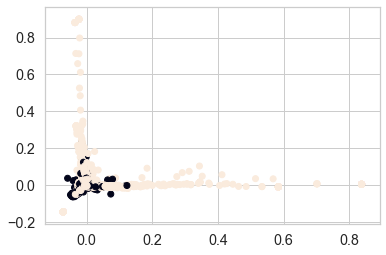

In [804]:
pca = PCA(n_components=2)
pca.fit(train_tfidf.todense())
data2D = pca.transform(train_tfidf.todense())
plt.scatter(data2D[:,0], data2D[:,1], c=train.target)
plt.show()  

# Logistic Regression Classifier

In [770]:
#Fitting on Counter Vectoriser
clf = LogisticRegression(C=1.0)
scorecount = model_selection.cross_val_score(clf, train_vectors, train['target'], cv=5, scoring="f1")

In [817]:
clf.fit(train_vectors, train['target'])

AttributeError: 'LogisticRegression' object has no attribute 'summary'

In [772]:
# Fitting on TFIDF
clf_tfidf = LogisticRegression(C=1.0)
scoretfidf = model_selection.cross_val_score(clf_tfidf, train_tfidf, train['target'], cv=5, scoring="f1")

In [773]:
model = model.append({'Model':'Logr',
                     'Count':scorecount.mean(),
                     'TFIDF':scoretfidf.mean()}, ignore_index=True)

# Naives Bayes Classifier

In [807]:
#Fitting on Counter Vectoriser
clf_NB = MultinomialNB()
scorecount = model_selection.cross_val_score(clf_NB, train_vectors, train["target"], cv=5, scoring="f1")

In [808]:
# Fitting on TFIDF
clf_NB_TFIDF = MultinomialNB()
scoretfidf = model_selection.cross_val_score(clf_NB_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")

In [809]:
clf_NB_TFIDF.fit(train_tfidf, train["target"])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [810]:
model = model.append({'Model':'Bayes',
                     'Count':scorecount.mean(),
                     'TFIDF':scoretfidf.mean()}, ignore_index=True)

# XGBoost

In [781]:
#Fitting on Counter Vectoriser
clf_xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
scorecount = model_selection.cross_val_score(clf_xgb, train_vectors, train["target"], cv=5, scoring="f1")

In [782]:
# Fitting on TFIDF
clf_xgb_TFIDF = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
scoretfidf = model_selection.cross_val_score(clf_xgb_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")

In [783]:
model = model.append({'Model':'XGB',
                     'Count':scorecount.mean(),
                     'TFIDF':scoretfidf.mean()}, ignore_index=True)

In [811]:
model

,Model,Count,TFIDF
0,Logr,0.579306,0.555490
1,Bayes,0.662336,0.634311
2,XGB,0.441528,0.444920
3,Bayes,0.662336,0.634311


# Glove

In [815]:
embeddings_dict = {}
with open('glove.6B.100d.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector